In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg
from mindstorm import dsmplot
from mindstorm import statplot
from tesser import tasks
from tesser import network
from tesser import model
from tesser import figures

main_dir = os.environ['TESSER_DIR']
data_dir = os.path.join(main_dir, 'Data')
fig_dir = os.path.join(main_dir, 'Figures', 'plots')

In [2]:
struct = tasks.load_struct(data_dir)
induct = tasks.load_induct(data_dir)

In [3]:
nodes = network.node_info()
comm = nodes['community'].to_numpy()
within_mat = (comm == comm[:, None]).astype(float)

In [4]:
fixed = {'alpha': 0.1}
var_names = ['gamma', 'w1', 'w2', 'w3', 'tau']
var_bounds = {
    'alpha': [0, 1],
    'gamma': [0, 1],
    'tau': [0, 10],
    'w1': [0, 1],
    'w2': [0, 1],
    'w3': [0, 1],
}
sim1_spec = {'alpha': 'alpha', 'gamma': 'gamma'}
sim2_spec = {'sim': within_mat}
question_param = {
    'central': {'w': 'w1'}, 'boundary1': {'w': 'w2'}, 'boundary2': {'w': 'w3'}
}
full_results = model.fit_induct(
    struct,
    induct,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
    n_job=6,
    n_rep=5,
)

In [5]:
full_results

,logl,n,k,alpha,gamma,w1,w2,w3,tau
rep,,,,,,,,,
0,-1042.021088,1554,5,0.1,0.000000,0.565584,0.997743,0.0,1.308601
1,-1042.021088,1554,5,0.1,0.000000,0.565640,0.997782,0.0,1.308565
2,-1042.021088,1554,5,0.1,0.000000,0.565621,0.997747,0.0,1.308577
3,-1041.649144,1554,5,0.1,0.982935,0.787874,1.000000,0.0,1.429575
4,-1042.021088,1554,5,0.1,0.000000,0.565619,0.997747,0.0,1.308577


In [6]:
results = model.get_best_results(full_results)
results

,logl,n,k,alpha,gamma,w1,w2,w3,tau
rep,,,,,,,,,
3,-1041.649144,1554,5,0.1,0.982935,0.787874,1.0,0.0,1.429575


In [47]:
f'{results.loc[3, "w3"]:.20f}'

'0.00000000000000000000'

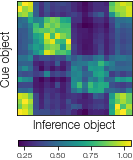

In [112]:
s1 = struct.query('subject == 100')
sr = model.learn_struct_sr(s1, results['gamma'], results['alpha'], 21)

fig, ax = plt.subplots(figsize=(3, 3))
h = dsmplot.plot_dsm(sr, prange=(0, 100), checks=False, ax=ax);
fig.colorbar(h, location='bottom', shrink=0.677);
ax = plt.gca()
ax.set_axis_on()
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Inference object', size='large')
ax.set_ylabel('Cue object', size='large')
plt.savefig(os.path.join(fig_dir, 'temporal_bias_model-sr-comm-qw_a10_t10_sr.pdf'))

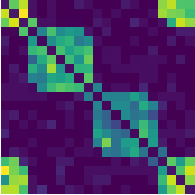

In [10]:
from tesser import tasks
s1 = tasks.load_struct(data_dir, [100])
sr = model.learn_struct_sr(s1, 0.99, 0.001, 21)
fig, ax = plt.subplots(figsize=(3, 3))
h = dsmplot.plot_dsm(sr, prange=(0, 100), checks=False, ax=ax);

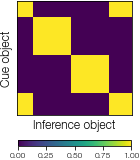

In [114]:
fig, ax = plt.subplots(figsize=(3, 3))
h = dsmplot.plot_dsm(within_mat, prange=(0, 100), checks=False, ax=ax)
fig.colorbar(h, location='bottom', shrink=0.677);
ax = plt.gca()
ax.set_axis_on()
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Inference object', size='large')
ax.set_ylabel('Cue object', size='large')
plt.savefig(os.path.join(fig_dir, 'temporal_bias_model_within.pdf'))

In [19]:
temp = results.copy()
temp['tau'] = .1
stats = model.get_fitted_prob(
    temp,
    induct,
    struct,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
)
stats

,subject,trial,trial_type,environment,community,cue,opt1,opt2,within,response,response_time,correct,prob
0,100,1,central,ocean,1,2,16,20,2,NaN,NaN,NaN,0.999084
1,100,2,boundary2,desert,2,4,10,19,1,2.0,2.974157,0.0,0.000045
2,100,3,central,desert,2,5,6,2,1,1.0,3.190848,1.0,0.995772
3,100,4,central,ocean,1,2,9,19,2,2.0,3.373906,1.0,0.998858
4,100,5,central,ocean,1,1,19,13,1,2.0,3.094699,0.0,0.000436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,138,38,central,desert,2,8,9,21,1,2.0,2.025821,0.0,0.035246
1550,138,39,central,forest,3,14,19,15,2,2.0,1.997691,1.0,0.993856
1551,138,40,central,ocean,1,21,14,2,2,2.0,1.114204,1.0,0.998878
1552,138,41,boundary1,forest,3,11,10,16,2,1.0,0.623270,0.0,0.021609


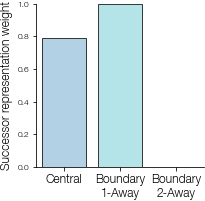

In [67]:
colors = figures.get_induct_colors()
rm = results.melt(value_vars=['w1', 'w2', 'w3'], var_name='parameter')
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data=rm,
    x='parameter',
    y='value',
    dodge=True,
    palette=colors['light'],
    edgecolor='k',
    linewidth=0.75,
    ax=ax,
);
ax.set(
    ylabel='Successor representation weight',
    xlabel='',
    ylim=(0, 1),
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
)
ax.tick_params(axis='x', labelsize='large');
fig.savefig(os.path.join(fig_dir, 'temporal_bias_param-sr-comm-qw_a10_t10.pdf'))

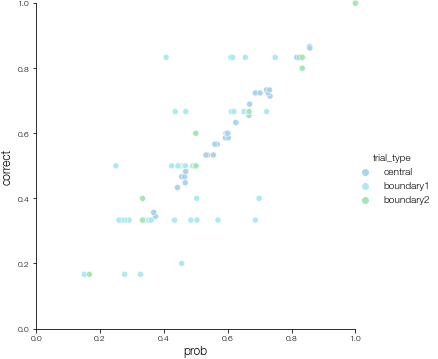

In [20]:
m = stats.groupby(['subject', 'trial_type'])[['correct', 'prob']].mean()

g = sns.relplot(
    data=m.reset_index(), x='prob', y='correct', hue='trial_type', clip_on=False, palette=colors['light']
)
g.set(xlim=(0, 1), ylim=(0, 1));

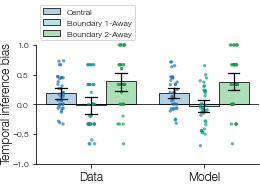

In [40]:
ml = pd.melt(
    m.reset_index(),
    id_vars=['subject', 'trial_type'],
    value_vars=['correct', 'prob'],
    var_name='source',
    value_name='accuracy',
)
ml['bias'] = (ml['accuracy'] - .5) * 2
ml['source'] = ml['source'].map({'correct': 'Data', 'prob': 'Model'})
ml['trial_type'] = ml['trial_type'].map(
    {
        'central': 'Central',
        'boundary1': 'Boundary 1-Away',
        'boundary2': 'Boundary 2-Away',
    }
)
fig, ax = plt.subplots(figsize=(4, 3))
statplot.plot_swarm_bar(
    data=ml,
    x='source',
    y='bias',
    hue='trial_type',
    dodge=True,
    point_kind='strip',
    light=colors['light'],
    dark=colors['dark'],
    bar_kws={'capsize': .1},
    ax=ax,
);
ax.set(ylabel='Temporal inference bias', ylim=(-1, 1.75), yticks=np.arange(-1, 1.5, .5));
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
ax.spines['left'].set_bounds(-1, 1)
ax.legend(loc='upper left', fontsize='small')
ax.yaxis.set_label_coords(-.1, 0.371)
fig.savefig(os.path.join(fig_dir, 'temporal_bias_model-sr-comm-qw_a10_t10.pdf'))